In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)
# tf.config.run_functions_eagerly(True)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from tqdm import tqdm
from icecream import ic

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files, scales, power_spectra, parameters

from deep_lss.models.grid_model import GridLossModel
from deep_lss.utils import optimization, configuration
from deep_lss.nets.mlp import MultiLayerPerceptron

from msi.utils import preprocessing, dataset

In [3]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml")
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias"
mocks = ["Buzzard", "Cardinal"]

# msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias_octant.yaml")
# base_dir = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias_octant"
# mocks = ["MICE"]

# for the white noise level
dlss_conf = configuration.load_deep_lss_config("/global/u2/a/athomsen/y3-deep-lss/configs/v10/combined/dlss_config.yaml")
# dlss_conf = configuration.load_deep_lss_config("/global/u2/a/athomsen/y3-deep-lss/configs/v10/combined/dlss_high_noise.yaml")

24-09-19 23:58:38 configuratio INF   Loaded the config 


In [4]:
# with_lensing = True
# with_clustering = False
# params = ["Om", "s8", "w0", "Aia", "n_Aia"]

In [5]:
with_lensing = False
with_clustering = True
params = ["Om", "s8", "w0", "bg", "n_bg"]

In [6]:
# with_lensing = True
# with_clustering = True
# params = ["Om", "s8", "w0", "Aia", "n_Aia", "bg", "n_bg"]

In [7]:
with_cross_z = False

apply_log = True

# l_mins=8*[0]
# l_maxs=8*[1500]
l_mins = None
l_maxs = None

# white noise dset

24-09-20 00:01:04 configuratio INF   Loaded the config 
24-09-20 00:01:04 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021  165.89861751
  242.69662921  316.71554252  378.94736842] from the dlss config 
24-09-20 00:01:04 preprocessin INF   Using l_mins = [0. 0. 0. 0. 0. 0. 0. 0.] by default (no smoothing) 
24-09-20 00:01:04 preprocessin INF   Using n_bins = 33 from the msfm config 
24-09-20 00:01:04 preprocessin INF   Loading the pre-binned Cls 
24-09-20 00:01:04 input_output INF   Array shapes: 
24-09-20 00:01:04 input_output INF   fiducial/i_example = (35920,) 
24-09-20 00:01:04 input_output INF   fiducial/i_noise   = (35920,) 
24-09-20 00:01:04 input_output INF   fiducial/cls/binned = (35920, 32, 36) 
24-09-20 00:01:04 input_output INF   fiducial/cls/bin_edges = (33, 36) 
24-09-20 00:01:04 input_output INF   grid/cosmo         = (2500, 400, 12) 
24-09-20 00:01:04 input_output INF   grid/i_example     = (2500, 400) 
24-09-20 00:01:04 input_ou

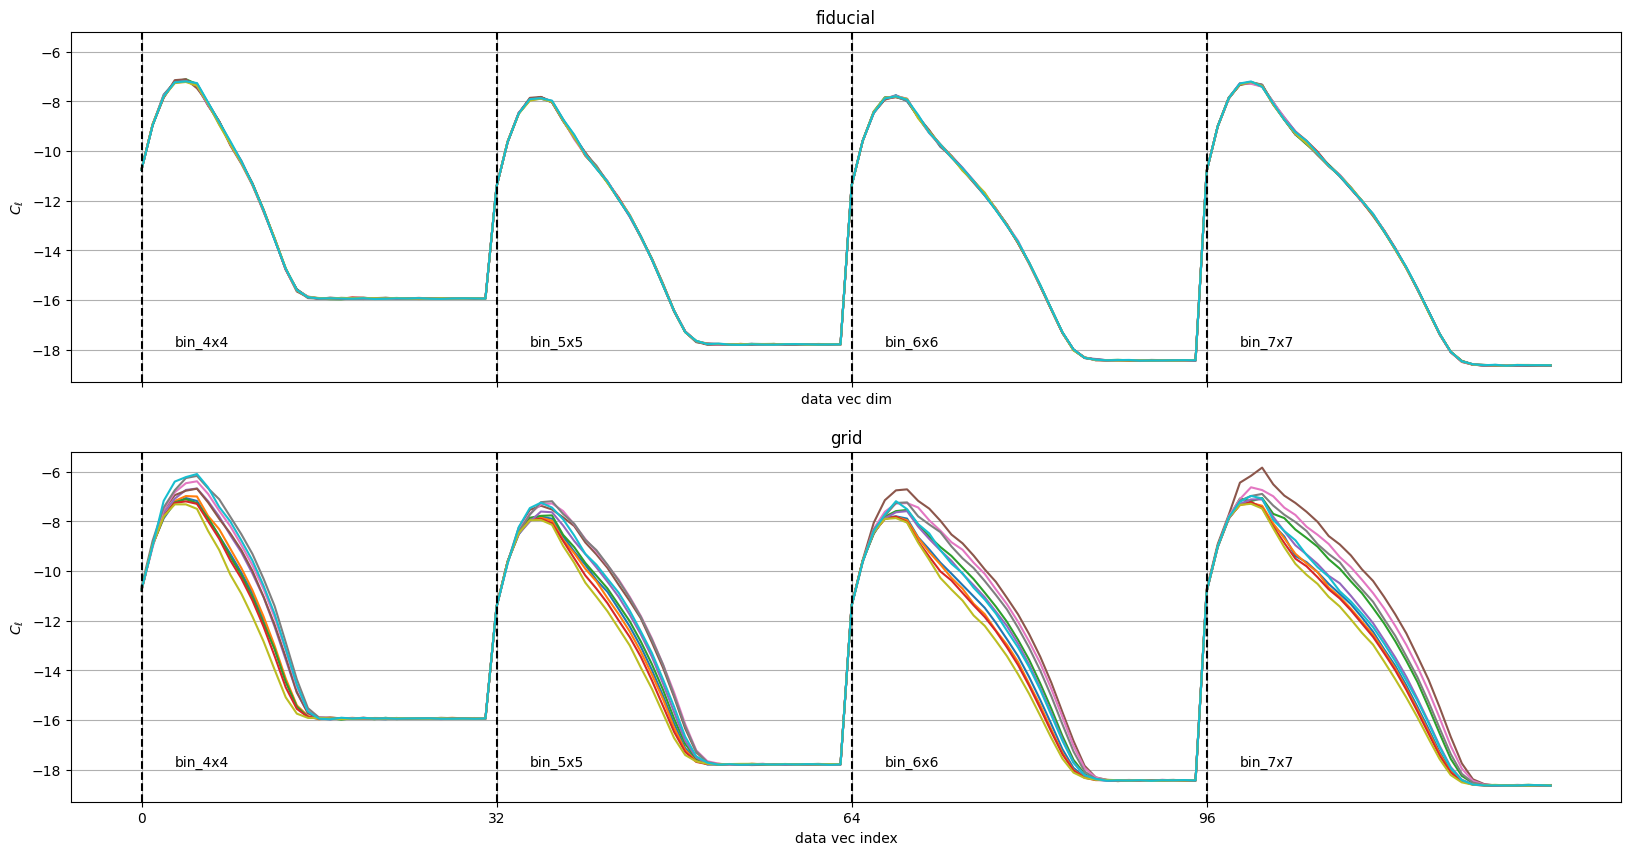

In [12]:
cl_dset_train, cl_dset_test, out_dict = dataset.get_binned_power_spectra_dset(
    base_dir, 
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    params=params,
    # selection
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_cross_z=with_cross_z,
    with_gaussian_noise=True,
    # with_gaussian_noise=False,
    # power spectra
    # l_mins=l_mins,
    # l_maxs=l_maxs,
    # n_bins=n_bins,
    # preprocessing
    apply_log=apply_log,
    # standardize=standardize,
)

# observation

24-09-20 00:04:33     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-20 00:04:33 configuratio INF   Loaded the config 
24-09-20 00:04:33 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021  165.89861751
  242.69662921  316.71554252  378.94736842] from the dlss config 
24-09-20 00:04:33 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
24-09-20 00:04:33     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-20 00:04:33     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-20 00:04:50 preprocessin INF   Adding white noise to the observation 
24-09-20 00:04:50 preprocessin INF   Taking the logarithm of the absolute values. 


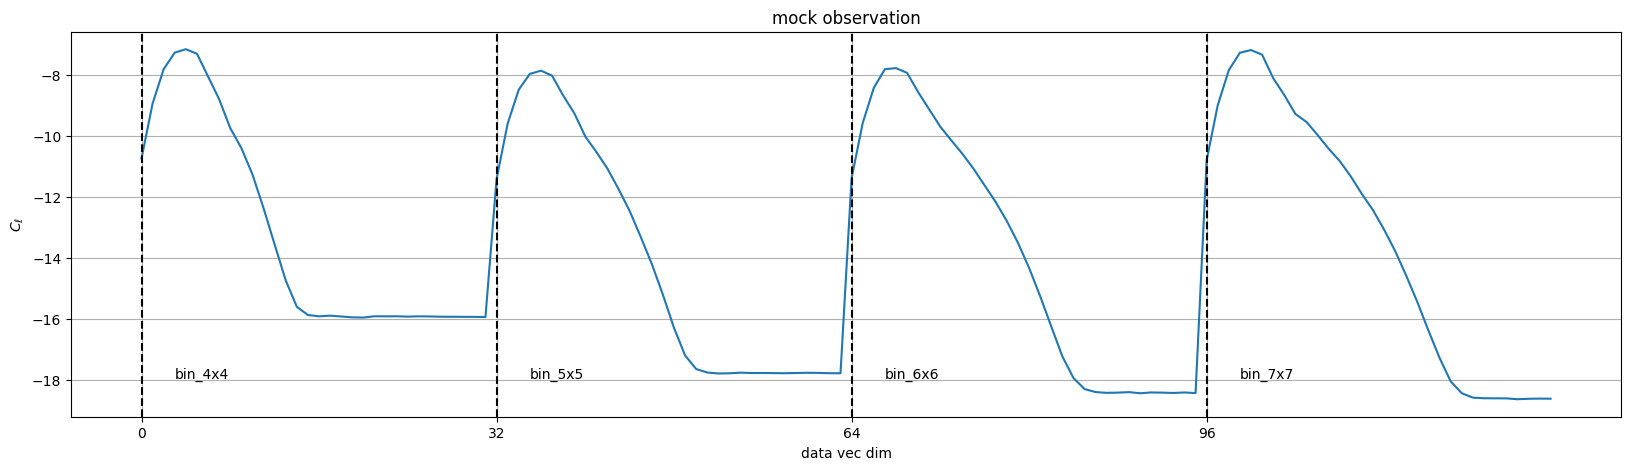

In [13]:
n_side = msfm_conf["analysis"]["n_side"]
n_pix = msfm_conf["analysis"]["n_pix"]
data_vec_pix = files.load_pixel_file(msfm_conf)[0]
hp_datapath = "/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/healpy_data"
    
obs_label = "Buzzard"
# obs_label = "Cardinal"
# obs_label = "MICE"

obs_file = f"/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/mock_observations/DESY3_mock_observation_{obs_label}.h5"

with h5py.File(obs_file, "r") as f_in:
    gc_map = []
    for i in range(1,5):
        gc_map.append(f_in[f"maglim/galaxy_counts_bin{i}"][:])
    gc_map = np.stack(gc_map, axis=-1)

obs_cl = preprocessing.get_preprocessed_cl_observation(
    wl_gamma_map=np.zeros((n_pix,4,2)),
    gc_count_map=gc_map,
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    base_dir=base_dir,
    # from_raw_cls=False,
    # selection
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_cross_z=with_cross_z,
    # with_cross_probe=with_lensing and with_clustering,
    # CLs scale cuts
    # l_mins=l_mins,
    # l_maxs=l_maxs,
    # n_bins=n_bins,
    # additional preprocessing
    apply_log=apply_log,
    # standardize=standardize,
    # scaler=scaler,
    # pca_components=None,
    # pca=pca,
)

# hp.mollview(gc_map[:,0])

# comparison

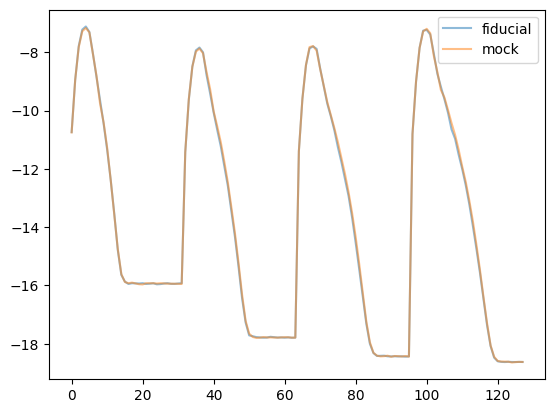

In [14]:
fidu_ex = out_dict["fidu/cls"][0,:]
mock_ex = np.squeeze(obs_cl)

fig, ax = plt.subplots()

ax.plot(fidu_ex, label="fiducial", alpha=0.5)
ax.plot(mock_ex, label="mock", alpha=0.5)

ax.legend(loc="best")
# ax.set(yscale="log")

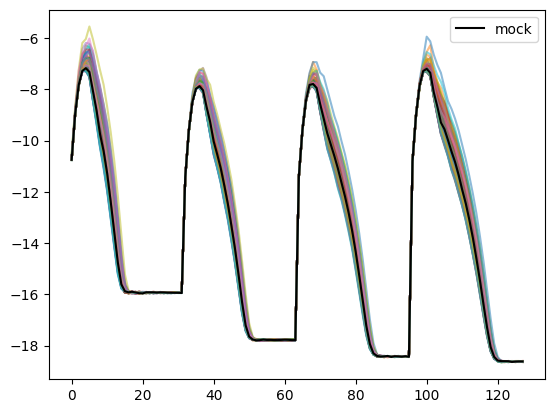

In [15]:
grid_ex = out_dict["grid/cls/test"][np.random.randint(0, out_dict["grid/cls/test"].shape[0], 100),:].T
mock_ex = np.squeeze(obs_cl)

fig, ax = plt.subplots()

ax.plot(grid_ex, alpha=0.5)
ax.plot(mock_ex, label="mock", color="k")

ax.legend(loc="best")
# ax.set(yscale="log")

In [ ]:
# fidu_file = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/cls/debug/fiducial_cls.h5"
# with h5py.File(fidu_file, "r") as f:
#     from_file = f["cls/binned"][:]
    
# print(from_file.shape)

# fig, ax = plt.subplots()

# ax.plot(from_file[0,:,26], label="from file", alpha=0.3)
# ax.plot(fidu_ex, label="fiducial", alpha=0.3)
# ax.plot(mock_ex, label="mock", alpha=0.3)

# ax.legend(loc="best")
# ax.set(yscale="log")